# Predicting football match outcomes

Kaggle competition to predict outcomes of association football matches.

In [53]:
import pandas as pd
from enum import Enum, auto
from functools import reduce
import seaborn as sns
pd.set_option('display.max_columns', None)

In [9]:
df = pd.read_csv('data\\train.csv')

C:\Users\Jack\AppData\Local\Temp\ipykernel_17520\2826050934.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data\\train.csv')


In [10]:
df.head()

,id,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id,away_team_coach_id,home_team_history_match_date_1,home_team_history_match_date_2,home_team_history_match_date_3,home_team_history_match_date_4,home_team_history_match_date_5,home_team_history_match_date_6,home_team_history_match_date_7,home_team_history_match_date_8,home_team_history_match_date_9,home_team_history_match_date_10,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,home_team_history_is_play_home_7,home_team_history_is_play_home_8,home_team_history_is_play_home_9,home_team_history_is_play_home_10,home_team_history_is_cup_1,home_team_history_is_cup_2,home_team_history_is_cup_3,home_team_history_is_cup_4,home_team_history_is_cup_5,home_team_history_is_cup_6,home_team_history_is_cup_7,home_team_history_is_cup_8,home_team_history_is_cup_9,home_team_history_is_cup_10,home_team_history_goal_1,home_team_history_goal_2,home_team_history_goal_3,home_team_history_goal_4,home_team_history_goal_5,home_team_history_goal_6,home_team_history_goal_7,home_team_history_goal_8,home_team_history_goal_9,home_team_history_goal_10,home_team_history_opponent_goal_1,home_team_history_opponent_goal_2,home_team_history_opponent_goal_3,home_team_history_opponent_goal_4,home_team_history_opponent_goal_5,home_team_history_opponent_goal_6,home_team_history_opponent_goal_7,home_team_history_opponent_goal_8,home_team_history_opponent_goal_9,home_team_history_opponent_goal_10,home_team_history_rating_1,home_team_history_rating_2,home_team_history_rating_3,home_team_history_rating_4,home_team_history_rating_5,home_team_history_rating_6,home_team_history_rating_7,home_team_history_rating_8,home_team_history_rating_9,home_team_history_rating_10,home_team_history_opponent_rating_1,home_team_history_opponent_rating_2,home_team_history_opponent_rating_3,home_team_history_opponent_rating_4,home_team_history_opponent_rating_5,home_team_history_opponent_rating_6,home_team_history_opponent_rating_7,home_team_history_opponent_rating_8,home_team_history_opponent_rating_9,home_team_history_opponent_rating_10,home_team_history_coach_1,home_team_history_coach_2,home_team_history_coach_3,home_team_history_coach_4,home_team_history_coach_5,home_team_history_coach_6,home_team_history_coach_7,home_team_history_coach_8,home_team_history_coach_9,home_team_history_coach_10,home_team_history_league_id_1,home_team_history_league_id_2,home_team_history_league_id_3,home_team_history_league_id_4,home_team_history_league_id_5,home_team_history_league_id_6,home_team_history_league_id_7,home_team_history_league_id_8,home_team_history_league_id_9,home_team_history_league_id_10,away_team_history_match_date_1,away_team_history_match_date_2,away_team_history_match_date_3,away_team_history_match_date_4,away_team_history_match_date_5,away_team_history_match_date_6,away_team_history_match_date_7,away_team_history_match_date_8,away_team_history_match_date_9,away_team_history_match_date_10,away_team_history_is_play_home_1,away_team_history_is_play_home_2,away_team_history_is_play_home_3,away_team_history_is_play_home_4,away_team_history_is_play_home_5,away_team_history_is_play_home_6,away_team_history_is_play_home_7,away_team_history_is_play_home_8,away_team_history_is_play_home_9,away_team_history_is_play_home_10,away_team_history_is_cup_1,away_team_history_is_cup_2,away_team_history_is_cup_3,away_team_history_is_cup_4,away_team_history_is_cup_5,away_team_history_is_cup_6,away_team_history_is_cup_7,away_team_history_is_cup_8,away_team_history_is_cup_9,away_team_history_is_cup_10,away_team_history_goal_1,away_team_history_goal_2,away_team_history_goal_3,away_team_history_goal_4,away_team_history_goal_5,away_team_history_goal_6,away_team_history_goal_7,away_team_history_goal_8,away_team_history_goal_9,away_team_history_goal_10,away_team_history_

In [16]:
df.shape

(110938, 190)

In [41]:
class Outcome(Enum):
    WIN = auto()
    LOSS = auto()
    DRAW = auto()

# provided a row, determines the outcome for the 'home' or 'away' team of the nth game they played in the past
# -1 for loss, 0 for draw, 1 for win
def get_team_game_outcome(x, team, game_n):
    if team.lower() not in ['home', 'away']:
        raise ValueError("Team must be 'home' or 'away'")
    team_goal_column = f"{team}_team_history_goal_{game_n}"
    opponent_goal_column = f"{team}_team_history_opponent_goal_{game_n}"
    team_goal_count = x[team_goal_column]
    opponent_goal_count = x[opponent_goal_column]
    if team_goal_count > opponent_goal_count:
        return Outcome.WIN
    elif team_goal_count < opponent_goal_count:
        return Outcome.LOSS
    else:
        return Outcome.DRAW

def get_team_historical_league_pts(x, team):
    if team.lower() not in ['home', 'away']:
        raise ValueError("Team must be 'home' or 'away'")

    game_outcomes = [get_team_game_outcome(x, team, y) for y in range(1,11)]

    def accumulate_league_pts(prev_pts, outcome):
        if outcome == Outcome.WIN:
            prev_pts += 3
        elif outcome == Outcome.DRAW:
            prev_pts += 1
        return prev_pts
    
    return reduce(accumulate_league_pts, game_outcomes, 0)

def get_home_team_historical_league_points(x):
    return get_team_historical_league_pts(x, 'home')

def get_away_team_historical_league_points(x):
    return get_team_historical_league_pts(x, 'away')

In [45]:
df.iloc[0].home_team_history_goal_1

0.0

In [50]:
df1 = df.apply(get_home_team_historical_league_points, axis=1)
df1.value_counts()

10    8338
12    8174
13    8042
14    7959
11    7896
15    7368
16    6783
9     6608
17    6187
8     5426
18    5232
19    4780
7     4108
20    3918
6     3027
21    3003
22    2509
5     2167
23    2035
4     1489
24    1318
25    1169
3      819
26     676
2      502
28     415
27     363
1      357
30     138
0      132
dtype: int64

In [52]:
df1.value_counts().sort_index()

0      132
1      357
2      502
3      819
4     1489
5     2167
6     3027
7     4108
8     5426
9     6608
10    8338
11    7896
12    8174
13    8042
14    7959
15    7368
16    6783
17    6187
18    5232
19    4780
20    3918
21    3003
22    2509
23    2035
24    1318
25    1169
26     676
27     363
28     415
30     138
dtype: int64

<AxesSubplot:ylabel='Count'>

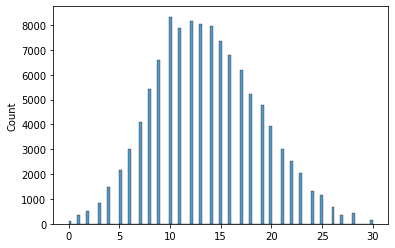

In [54]:
sns.histplot(df1)